In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [2]:
os.chdir("../Dataset")

In [3]:
dataset = pd.read_csv("FeatureExtracted/dataset.csv")
ratings_train = pd.read_csv("CleanedData/ratings_train.csv")
ratings_test = pd.read_csv("CleanedData/ratings_test.csv")

## Content-Based Recommendation System - Pytorch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

### Make Dataset For Train

There are 671 users

In [5]:
len_users = ratings_train['userId'].unique().size
print(len_users)

671


2830 movies

In [6]:
len_dataset = len(dataset)
print(len_dataset)

2830


We need to save the id for later recommendation

In [7]:
dataset

,budget,id,runtime,revenue,vote_average,vote_count,CastsRank,NumLeadActors,HasTop50Actors,NumCrews,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,60000000,949,170.0,187436818.0,7.7,1886.0,13852,3,0,71,...,0,0,0,0,0,0,0,1,0,0
1,58000000,710,130.0,352194034.0,6.6,1194.0,5916,3,1,46,...,0,0,0,0,0,0,0,1,0,0
2,98000000,1408,119.0,10017322.0,5.7,137.0,3481,0,0,16,...,0,0,0,0,0,0,0,0,0,0
3,52000000,524,178.0,116112375.0,7.8,1343.0,6894,0,0,10,...,0,0,0,0,0,0,0,0,0,0
4,16500000,4584,136.0,135000000.0,7.2,364.0,4392,2,1,8,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,0,80831,121.0,0.0,6.5,2.0,1374,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2826,0,3104,92.0,0.0,5.9,33.0,1054,0,0,11,...,0,1,0,0,0,1,0,0,0,0
2827,0,64197,97.0,0.0,6.0,5.0,729,0,0,4,...,0,0,0,0,1,0,0,0,0,0
2828,0,98604,91.0,0.0,4.6,6.0,2385,0,0,4,...,0,0,0,0,1,0,0,0,0,0


In [8]:
indexToId = dict(zip(dataset.index, dataset['id']))
idToIndex = dict(zip(dataset['id'], dataset.index))

In [9]:
indexToId[0]

949

In [10]:
dataset.drop(columns = ['id'], inplace = True)

Standardlize the dataset by each column to mean of 0 and standard deviation of 1

In [11]:
from sklearn import preprocessing

In [12]:
dataset = preprocessing.scale(dataset)

In [13]:
len_features = dataset.shape[1]

Test Transfrom Metadata Movies Dataframe to Tensor

In [14]:
movies_tensor = torch.tensor(dataset, requires_grad= False)

Test Transform Ratings to Sparse Tensor

In [15]:
ratings_train["movieId"] = ratings_train["movieId"].apply(lambda x: idToIndex[x])

In [16]:
ratings_test["movieId"] = ratings_test["movieId"].apply(lambda x: idToIndex[x])

In [17]:
len(ratings_train['userId'].unique()) == len(ratings_test['userId'].unique())

True

In [18]:
ratings_train["userId"] = ratings_train["userId"].apply(lambda x: x - 1)
ratings_test["userId"] = ratings_test["userId"].apply(lambda x: x - 1)

In [19]:
ratings_train

,userId,movieId,rating
0,0,474,2.5
1,0,618,2.0
2,0,835,2.0
3,0,1614,2.5
4,1,1618,5.0
...,...,...,...
31185,670,1454,5.0
31186,670,769,4.5
31187,670,337,4.0
31188,670,1235,3.5


In [20]:
ratings_tensor = torch.sparse_coo_tensor([ratings_train['userId'], ratings_train['movieId']], ratings_train['rating'], (len_users, len_dataset))

In [21]:
ratings_tensor[0][474]

tensor(2.5000, dtype=torch.float64)

All works normally!

Now we will put all those codes into one block

In [22]:
"""
This codes convert dataset to Tensor data structure
"""

movies_tensor = torch.tensor(dataset, requires_grad= False)
movies_tensor = torch.cat((movies_tensor, torch.ones(len_dataset, 1, dtype = torch.float64)), axis = 1)
ratings_train_tensor = torch.sparse_coo_tensor([ratings_train['userId'],\
                                                     ratings_train['movieId']],\
                                                     ratings_train['rating'], (len_users, len_dataset))
ratings_test_tensor = torch.sparse_coo_tensor([ratings_test['userId'],\
                                                     ratings_test['movieId']],\
                                                     ratings_test['rating'], (len_users, len_dataset))

ratings_train_tensor = ratings_train_tensor.to_dense()
ratings_test_tensor = ratings_test_tensor.to_dense()

In [23]:
from torch.autograd import Variable

In [24]:
ratings_train_tensor[0][474]

tensor(2.5000, dtype=torch.float64)

### Train

We proposed a Regression Model for predicting Ratings

To predict the rate from user model $U$ and movies profiles $M$:

$U$ * $M^\top$ = $\hat{R}$ 

$L = MSE(\hat{R}, R)$ for all movies that have rated 

Find the partial derivatives for matrix $U$ : $ \dfrac{\partial L}{\partial U} $

Update $U$ based on $ \dfrac{\partial L}{\partial U} $

To calculate derivatives, we use **Autograd** of ***Pytorch***

In [25]:
"""
Autograd example
"""
# ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
# mask = ratings_train_tensor.bool()
# nonzero_pred = ratings_pred.masked_select(mask)
# nonzero_train = ratings_train_tensor.masked_select(mask)
# loss = criterion(nonzero_pred, nonzero_train)
# loss.backward()

'\nAutograd example\n'

In [26]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

Here we use MSELoss (**Mean Square Error**)

We also use this loss as metrics

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([U], lr = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [28]:
from tqdm.notebook import tqdm

In [29]:
bestU = None
bestb = None
minLoss = 10e10

First try 3001 loop without regulization, lr = 0.005

In [30]:
EPOCH = 3001
trainLoss = []
testLoss = []
testEp = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = ratings_pred.masked_select(mask)
    nonzero_train = ratings_train_tensor.masked_select(mask)
    loss = criterion(nonzero_pred, nonzero_train)
    loss.backward()
    optimizer.step()
    trainLoss.append(loss.item())
    if ep % 10 == 0:
      testEp.append(ep)
      mask = ratings_test_tensor.bool()
      nonzero_pred = ratings_pred.masked_select(mask)
      nonzero_test = ratings_test_tensor.masked_select(mask)
      loss_test = criterion(nonzero_pred, nonzero_test)
      testLoss.append(loss_test.item())
      if minLoss > loss_test:
        bestU = U
        bestb = b
        minLoss = loss_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Valid Loss: {loss_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 64.10655643566844. Valid Loss: 62.37670454644261.
Epoch: 10. Train Loss: 56.6606566141118. Valid Loss: 56.805391539242244.
Epoch: 20. Train Loss: 50.25430154906511. Valid Loss: 52.08661616749644.
Epoch: 30. Train Loss: 44.79605361231597. Valid Loss: 48.12330855560293.
Epoch: 40. Train Loss: 40.15082464491162. Valid Loss: 44.78968902764665.
Epoch: 50. Train Loss: 36.185571582150814. Valid Loss: 41.96866450447321.
Epoch: 60. Train Loss: 32.78295980867981. Valid Loss: 39.56406021635322.
Epoch: 70. Train Loss: 29.84458041398937. Valid Loss: 37.49865484352405.
Epoch: 80. Train Loss: 27.290214368687977. Valid Loss: 35.71052548383428.
Epoch: 90. Train Loss: 25.055245258972278. Valid Loss: 34.15060221266894.
Epoch: 100. Train Loss: 23.08767293314678. Valid Loss: 32.78067766909476.
Epoch: 110. Train Loss: 21.34553162542222. Valid Loss: 31.56991662270118.
Epoch: 120. Train Loss: 19.794780221858847. Valid Loss: 30.493296436739023.
Epoch: 130. Train Loss: 18.407622592229416. 

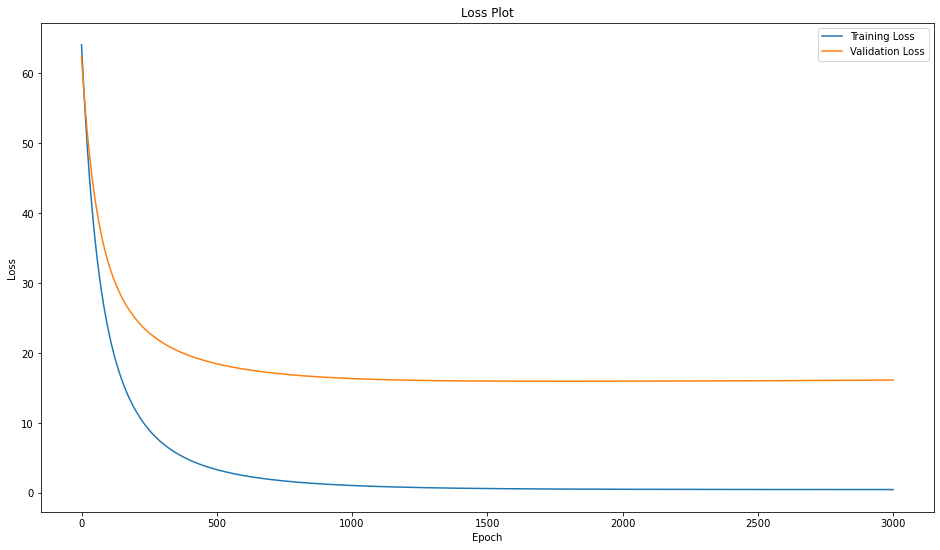

In [31]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

Now apply regularization weight_decay on U = 0.05 and lr = 0.005

In [32]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([U], lr = 0.005, weight_decay = 0.05)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [34]:
bestU = None
bestb = None
minLoss = 10e10

In [35]:
EPOCH = 3001
trainLoss = []
testLoss = []
testEp = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = ratings_pred.masked_select(mask)
    nonzero_train = ratings_train_tensor.masked_select(mask)
    loss = criterion(nonzero_pred, nonzero_train)
    loss.backward()
    optimizer.step()
    trainLoss.append(loss.item())
    if ep % 10 == 0:
      testEp.append(ep)
      mask = ratings_test_tensor.bool()
      nonzero_pred = ratings_pred.masked_select(mask)
      nonzero_test = ratings_test_tensor.masked_select(mask)
      loss_test = criterion(nonzero_pred, nonzero_test)
      testLoss.append(loss_test.item())
      if minLoss > loss_test:
        bestU = U
        bestb = b
        minLoss = loss_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Valid Loss: {loss_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 55.9389782447297. Valid Loss: 55.147542425539164.
Epoch: 10. Train Loss: 51.16576388078184. Valid Loss: 50.76424633776617.
Epoch: 20. Train Loss: 46.89062356850444. Valid Loss: 46.80002969246155.
Epoch: 30. Train Loss: 43.105702403406646. Valid Loss: 43.253849195431016.
Epoch: 40. Train Loss: 39.762101161333085. Valid Loss: 40.09216438898178.
Epoch: 50. Train Loss: 36.7943421420201. Valid Loss: 37.263062551182216.
Epoch: 60. Train Loss: 34.14371506174527. Valid Loss: 34.72015849898945.
Epoch: 70. Train Loss: 31.76326618245502. Valid Loss: 32.42544171070686.
Epoch: 80. Train Loss: 29.6161215018465. Valid Loss: 30.344087106954575.
Epoch: 90. Train Loss: 27.6700173608674. Valid Loss: 28.446966860467956.
Epoch: 100. Train Loss: 25.89867349219337. Valid Loss: 26.71109942035731.
Epoch: 110. Train Loss: 24.28072142326709. Valid Loss: 25.11804714841044.
Epoch: 120. Train Loss: 22.798566811160118. Valid Loss: 23.652150179779998.
Epoch: 130. Train Loss: 21.437215661816577. 

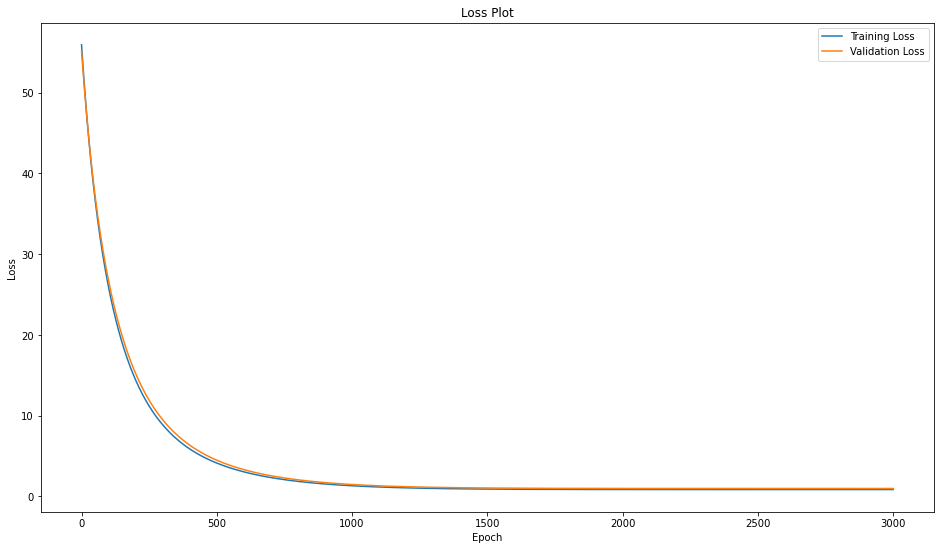

In [36]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

Take minLoss and bestU, bestb

In [37]:
minLoss

tensor(0.9748, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [38]:
bestU

tensor([[-4.6181e-05,  9.1841e-05,  5.4503e-04,  ..., -2.8541e-11,
         -8.9279e-12, -8.4979e-12],
        [-1.1335e-03, -1.2419e-02,  5.2176e-03,  ...,  2.4515e-05,
          7.1601e-03, -2.4875e-05],
        [ 1.6921e-03, -1.9156e-03, -1.5166e-03,  ...,  4.0575e-03,
         -2.9814e-03, -3.4898e-05],
        ...,
        [ 2.5991e-03, -1.2845e-03,  1.1771e-03,  ...,  3.7455e-03,
         -4.3664e-12, -3.5235e-12],
        [ 7.7401e-04, -2.1844e-03,  1.0291e-04,  ...,  3.0103e-03,
          1.1067e-02, -4.8461e-10],
        [-7.9729e-04, -1.4242e-03, -1.8596e-04,  ...,  4.8769e-03,
         -3.6594e-03, -8.5257e-03]], dtype=torch.float64, requires_grad=True)

In [39]:
bestU.detach().numpy().tofile("ModelStorage/U.txt")
bestb.detach().numpy().tofile("ModelStorage/b.txt")

In [40]:
with open("ModelStorage/indexToId.txt", "w+") as file:
  file.write(str(indexToId))
with open("ModelStorage/idToIndex.txt", "w+") as file:
  file.write(str(idToIndex))